In [1]:
%matplotlib inline
import matplotlib as mpl
import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

In [3]:
def sample_graph_from_infection(g):
    g_bone = g.copy()
    g = nx.Graph()
    g.add_nodes_from(g_bone)
    
    # sample active edges
    rands = np.random.random(g_bone.number_of_edges())
    
    probas = np.array([g_bone[i][j]['p'] for i, j in g_bone.edges_iter()])
    all_edges = g_bone.edges()
    active_edges = [all_edges[i] for i in (rands < probas).nonzero()[0]]

    g.add_edges_from(active_edges)
    
    for i, j in g.edges_iter():
        g[i][j]['tried'] = False
        g[i][j]['d'] = g_bone[i][j]['d']
        g[i][j]['p'] = g_bone[i][j]['p']        
        
    return g

In [4]:
def simulate_IC(g, s=None, debug=False):
    """return dict of node to infected times
    edges in g should contain the follow information:

    - d: the transmission delay
    - p: infection probability
    """
    infection_time = {n: float('inf') for n in g.nodes_iter()}
    bp = {n: None for n in g.nodes_iter()}  # back tracker
        
    g = sample_graph_from_infection(g)
    
    if debug:
        print(g.edges())
    if s is None:
        s = random.choice(g.nodes())
        
    queue = [s]
    t = 0
    infection_time[s] = t
    infection_paths = []
    while len(queue) > 0:
        outbreak_nodes = [u for u in queue if infection_time[u] <= t]
        queue = list(set(queue) - set(outbreak_nodes))
        infected_nodes = set()
        if debug:
            print('outbreak_nodes {}'.format(outbreak_nodes))
        for u in outbreak_nodes:
            for v in g.neighbors(u):
                if not g[u][v]['tried']:
                    if debug:
                        print('{} infects {}'.format(u, v))                    
                    g[u][v]['tried'] = True
                    if np.isinf(infection_time[v]):  # not infected yet
                        queue.append(v)

                    # update infection time
                    if (infection_time[u] + g[u][v]['d'] < infection_time[v]):
                        infection_time[v] = infection_time[u] + g[u][v]['d']
                        infected_nodes.add(v)
                        bp[v] = u
        if len(infected_nodes) == 0:
            break
        n = min(infected_nodes, key=lambda n: infection_time[n])
        t = infection_time[n]
    infection_tree = nx.Graph()
    infection_tree.add_nodes_from(g.nodes())
    del bp[s]
    infection_tree.add_edges_from(bp.items())
    return infection_time, infection_tree

In [82]:
g = nx.Graph()
a, b, c = 'a', 'b', 'c'
g.add_nodes_from([a, b, c])
g.add_edge(a, b, {'d': 3, 'p': 1})
g.add_edge(a, c, {'d': 1, 'p': 1})
g.add_edge(b, c, {'d': 1, 'p': 1})
t, tree = simulate_IC(g, s=a)
assert t == {'a': 0, 'b': 2, 'c': 1}
assert tree.edges() == [('a', 'c'), ('b', 'c')]

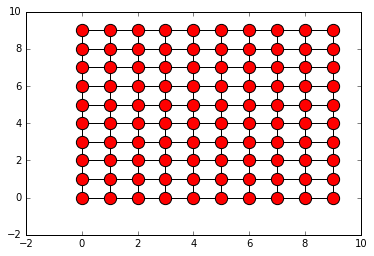

In [11]:
n = 10
g = nx.grid_2d_graph(n, n)
for i, j in g.edges_iter():
    g[i][j]['delay'] = 1
pos = {n: np.array(n) for n in g.nodes()}    
nx.draw_networkx(g, pos=pos, with_labels=False, node_size=150)

In [5]:
def prepare_standard_infection_graph(g, p):
    for i, j in g.edges_iter():
        g[i][j]['p'] = p
        g[i][j]['d'] = 1
    return g


def get_display_kwargs(g, infected_times, obs_nodes=set(), max_node_size=1000):
    diff = 1
    times = np.array(list(infected_times.values()))
    times = times[np.invert(np.isinf(times))]
    upper_bound = times.max() + diff
    node_colors = [((upper_bound - infected_times[n] + diff) if not np.isinf(infected_times[n]) else 0)
                   for n in g.nodes()]
    def node_size(n):
        if n in obs_nodes:
            return max_node_size
        elif not np.isinf(infected_times[n]):
            return max_node_size / 4
        else:
            return max_node_size / 10
    node_sizes = list(map(node_size, g.nodes()))
    return {'node_size': node_sizes,
            'node_color': node_colors,
            'cmap': 'OrRd'}

In [6]:
def add_colorbar(cvalues, cmap='OrRd'):
    eps = np.maximum(0.0000000001, np.min(cvalues)/1000.)
    vmin = np.min(cvalues) - eps
    vmax = np.max(cvalues)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scm = mpl.cm.ScalarMappable(norm, cmap)
    scm.set_array(cvalues)
    plt.colorbar(scm)    

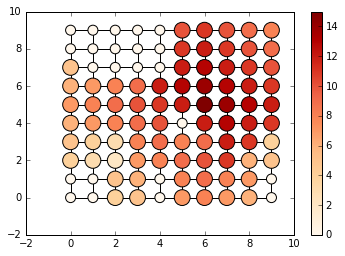

In [86]:
g = prepare_standard_infection_graph(g, infp)
infp = 0.6
infection_times, tree = simulate_IC(g)

kwargs =get_display_kwargs(g, infection_times)
nx.draw_networkx(g, pos=pos, with_labels=False, **kwargs)
add_colorbar(kwargs['node_color'])


In [70]:
def make_input(g, infp, fraction):
    while True:
        infection_times, tree = simulate_IC(g)

        cascade_size = np.count_nonzero(np.invert(np.isinf(list(infection_times.values()))))

        sample_size = int(cascade_size * fraction)
        infected_nodes = [n for n in g.nodes_iter() if not np.isinf(infection_times[n])]
        
        if sample_size > 1 and len(infected_nodes) > sample_size:
            break    
    
    obs_nodes = set(random.sample(infected_nodes, sample_size))
    source = min(infection_times, key=lambda n: infection_times[n])
    if source in obs_nodes:
        obs_nodes.remove(source)
    orig_obs_nodes = copy(obs_nodes)    
    obs_infection_times = {n: infection_times[n] for n in obs_nodes}
    print("{}/{} samples".format(len(obs_nodes), cascade_size))
    return orig_obs_nodes, infection_times, tree

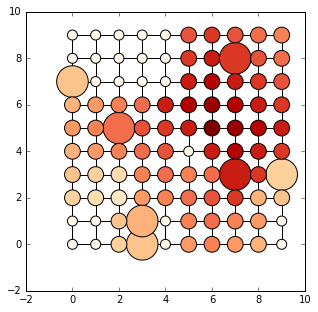

In [93]:
kwargs = get_display_kwargs(g, infection_times, obs_nodes)
fig = plt.figure(figsize=(5, 5))
nx.draw_networkx(g, pos=pos, with_labels=False, **kwargs)

In [14]:

def simulate_on_node_as_source(g, s, K, order_constraint_n, obs_nodes, infection_times):
    success_cnt = 0
    if order_constraint_n:
        ordered_pairs = random.sample(list(combinations(obs_nodes, 2)), order_constraint_n)
        ground_truth = np.array([infection_times[u] > infection_times[v] for u, v in ordered_pairs])

    for i in range(K):
        times, _ = simulate_IC(g, s=s)
        inf_nodes = filter(lambda n: not np.isinf(times[n]), times)
        if obs_nodes.issubset(set(inf_nodes)):
            if order_constraint_n:
                reality = np.array([times[u] > times[v] for u, v in ordered_pairs])
                if (ground_truth == reality).all():
                    success_cnt += 1
            else:
                success_cnt += 1
    return s, success_cnt

def estimate_source_likelihood(g, K, M, obs_nodes, infection_times):
    result = Parallel(n_jobs=-1)(delayed(simulate_on_node_as_source)(g, s, K, M, obs_nodes, infection_times)
                                 for s in g.nodes())
    df = pd.DataFrame(result, columns=['node', 'cnt'])
    df['mu'] = df['cnt'] / K

    # stored here
    mu = {r['node']: r['mu'] for i, r in df.iterrows()}
    return mu

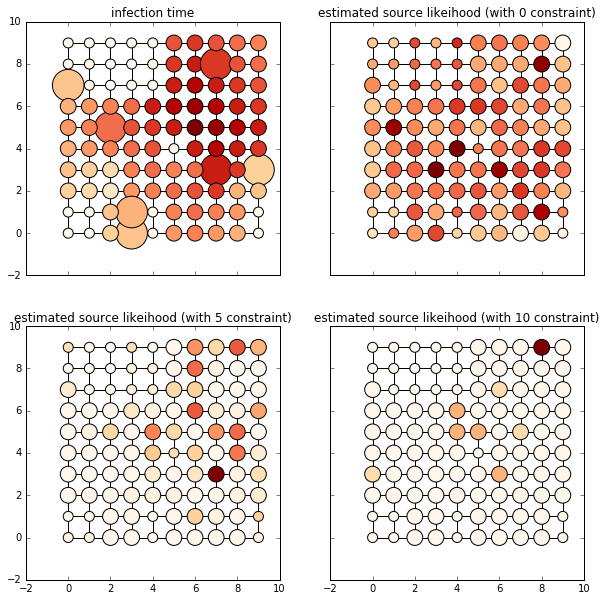

In [95]:
# source likelihood given observation
# using different number of constraints
K = 100
M = 5  # number of pairwise order constraints
fig, ax = plt.subplots(2, 2, num=1,
                       sharex=True, sharey=True,
                       figsize=(10, 10))


kwargs = get_display_kwargs(g, infection_times, obs_nodes)
nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
# add_colorbar(kwargs['node_color'])
ax[0, 0].set_title('infection time')

def run_with_n_constraints(M, i, j):
    kwargs = get_display_kwargs(g, infection_times, obs_nodes=set())
    mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
    kwargs['node_color'] = [mu.get(n, 0) for n in g.nodes()]
    nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
    ax[i, j].set_title('estimated source likeihood (with {} constraint)'.format(M))
# add_colorbar(kwargs['node_color'])
run_with_n_constraints(0, 0, 1)
run_with_n_constraints(5, 1, 0)
run_with_n_constraints(10, 1, 1)


In [57]:
def simulate_given_passing_edge(g, q, u, s, K, M, max_attempts, infection_times, obs_nodes=set()):
    """
    q: query node
    u: direction node
    s: source node
    K: valid cascade number
    M: number of order pairs"""
    attempts = 0
    valid_cnt = 0  # valid if q and u is infected
    success_cnt = 0
    if M:
        ordered_pairs = random.sample(list(combinations(obs_nodes, 2)), M)
        ground_truth = np.array([infection_times[u] > infection_times[v] for u, v in ordered_pairs])

    
    while valid_cnt < K and attempts < max_attempts:
        attempts += 1
        time, tree = simulate_IC(g, s=s)
        if not np.isinf(time[q]) and not np.isinf(time[u]):
            valid_cnt +=1 
            if tree.has_edge(q, u) and time[q] - time[u] == g[q][u]['d']:
                inf_nodes = set(filter(lambda n: not np.isinf(time[n]), time))
                if obs_nodes.issubset(inf_nodes):
                    if M:
                        reality = np.array([time[u] > time[v] for u, v in ordered_pairs])
                        if (ground_truth == reality).all():
                            success_cnt += 1
                    else:
                        success_cnt += 1
    return s, success_cnt


In [58]:
def estimate_source_likelihood_given_edge(g, q, u, K, M,
                                          max_attempts, infection_times, obs_nodes):
    cands = set(g.nodes()) - {q} - set(g.neighbors(q)) - obs_nodes
    result = Parallel(n_jobs=-1)(delayed(simulate_given_passing_edge)(g, q, u, s=s, 
                                                                        K=K, M=M,
                                                                        max_attempts=max_attempts,
                                                                        infection_times=infection_times,
                                                                        obs_nodes=obs_nodes)
                                    for s in cands)
    df = pd.DataFrame(result, columns=['node', 'cnt'])
    df['mu'] = df['cnt'] / K

    # stored here
    mu = {r['node']: r['mu'] for i, r in df.iterrows()}
    return mu

(7, 7)
(6, 7)


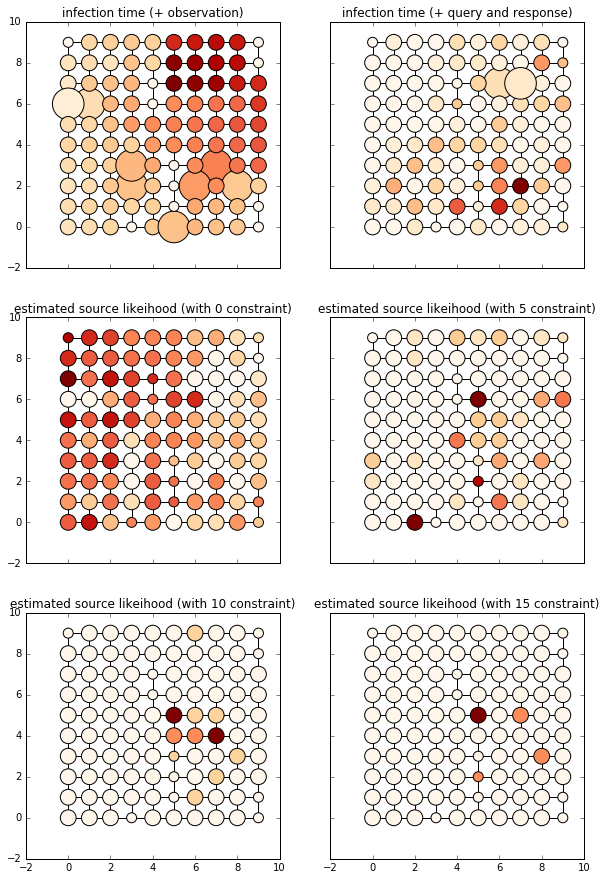

In [59]:
# fixing query and edge
# check the likelihood change with different number of node order constraints.
K = 50
M=5
max_attempts=200
q = random.choice(list(set(tree.nodes()) - obs_nodes))
print(q)
u = [u for u in g.neighbors(q)
     if infection_times[q] - infection_times[u] == g[q][u]['d']]
u = u[0]
print(u)

fig, ax = plt.subplots(3, 2, num=1, sharex=True, sharey=True,
                       figsize=(10, 15))


kwargs = get_display_kwargs(g, infection_times, obs_nodes)
nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
# add_colorbar(kwargs['node_color'])
ax[0, 0].set_title('infection time (+ observation)')

kwargs = get_display_kwargs(g, infection_times, {q, u})
mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
kwargs['node_color'] = [mu.get(n) for n in g.nodes()]
nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 1], **kwargs)
# add_colorbar(kwargs['node_color'])
ax[0, 1].set_title('infection time (+ query and response)')

def run_with_n_constraints(M, i, j):
    kwargs = get_display_kwargs(g, infection_times, obs_nodes=set())
    mu = estimate_source_likelihood_given_edge(g, q, u, K, M, max_attempts, infection_times, obs_nodes)
    kwargs['node_color'] = [mu.get(n, 0) for n in g.nodes()]
    nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
    ax[i, j].set_title('estimated source likeihood (with {} constraint)'.format(M))

run_with_n_constraints(0, 1, 0)
run_with_n_constraints(5, 1, 1)
run_with_n_constraints(10, 2, 0)
run_with_n_constraints(15, 2, 1)

In [133]:
print(infection_times[q])
print(infection_times[u])
q, u

3
2


((8, 6), (8, 5))

In [8]:
def get_nodes_on_and_off_direction(g, start, end):
    pos_nodes = set()
    neg_nodes = set()
    for t, path in nx.shortest_path(g, source=start).items():
        if len(path) == 1:
            pos_nodes.add(t)
        elif path[1] == end:
            # print(t, path)
            pos_nodes.add(t)
        else:
            neg_nodes.add(t)
    return pos_nodes, neg_nodes

In [138]:
q = (9, 7)
u = (8, 7)
pos_nods, neg_nodes = get_nodes_on_and_off_direction(g, q, u)

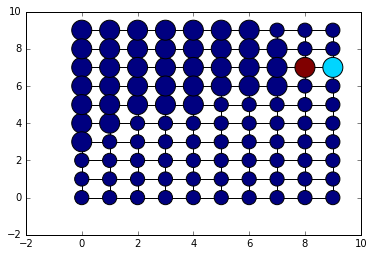

In [139]:
node_color = [1 if n == q else (3 if n == u else 0)
              for n in g.nodes() ]
nx.draw_networkx(g, pos=pos, 
                 node_color=node_color,
                 node_size=[400 if n in pos_nodes else 200 for n in g.nodes()],
                 with_labels=False)

In [41]:
# multiplicative weight update method
# initial mu
def mwu(g, orig_obs_nodes,
        infection_times, 
        p_on_mu, 
        mu, 
        max_iter, 
        max_plot_iter=11,
        debug=False, plot=False):
    use_sampling = False
    epsilon = 1e-5  # smoothing parameter
    obs_nodes = copy(orig_obs_nodes)
    K = 25
    M = len(obs_nodes)
    
    source = min(infection_times, key=lambda n: infection_times[n])
    

    K = 50
    max_attempts = 500

    sp_len = nx.shortest_path_length(g, weight='d')

    iter_i = 0

    if plot:
        ncols = 2
        nrows = math.ceil((max_plot_iter + 1) / ncols)
        width = 12
        height = int(width * nrows / ncols)
        fig, ax = plt.subplots(nrows, ncols,
                               sharex=True, sharey=True,
                               figsize=(width, height))
        kwargs = get_display_kwargs(g, infection_times, obs_nodes=obs_nodes)
        nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
        ax[0, 0].set_title('ground truth')

    cands = set(g.nodes())
    if debug:
        print('correct source is {}'.format(source))
    all_nodes = set(g.nodes())
    queried_nodes = set()
    while iter_i < max_iter:
        def phi(q, g, mu, sp_len):
            return np.sum([mu[v] * sp_len[q][v] for v in g.nodes_iter()])
        q = min(all_nodes, key=lambda q: phi(q, g, mu, sp_len))
        if debug:
            print('query node: {}'.format(q))

        if plot and iter_i+1 <= max_plot_iter:
            kwargs = get_display_kwargs(g, mu, obs_nodes={q})
            likelihood_colors = [mu.get(n, 0) for n in g.nodes()]

            i, j = int((iter_i + 1) / ncols), (iter_i + 1) % ncols
            kwargs['node_color'] = likelihood_colors
            nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
            ax[i, j].set_title('iter_i={}'.format(iter_i))

        if q not in obs_nodes:
            obs_nodes.add(q)
            queried_nodes.add(q)

        if np.isinf(infection_times[q]):  # q is uninfected        
            if debug:
                print('query is uninfected')
            mu[q] = 0
        else:        
            if debug:
                print('query is infected')
            found_source = True
            for u in g.neighbors(q):                
                if u not in obs_nodes:  # need to query it
                    obs_nodes.add(u)
                    queried_nodes.add(u)

                if infection_times[q] > infection_times[u]:
                    # q later than u                    
                    found_source = False
                    # found the direction
                    if infection_times[q] - infection_times[u] == g[q][u]['d']:
                        mu[q] = 0
                        if q in cands:
                            cands.remove(q)
                        break
                else:
                    # q earlier than u
                    mu[u] = 0
                    if u in cands:
                        cands.remove(u)
            
            if found_source:
                source = q
                expected = min(infection_times, key=lambda n: infection_times[n])
                print('**Found** source: {}'.format(source))
                assert source == expected
                print('query count {}'.format(len(queried_nodes)))
                break
            else:
                assert infection_times[q] - infection_times[u] == g[q][u]['d']
                if use_sampling:
                    # update likelihood                      
                    if debug:
                        print('M={}'.format(len(obs_nodes)))                    
                    result = Parallel(n_jobs=-1)(delayed(simulate_given_passing_edge)(g, q=q, u=u, s=s,
                                                                                      obs_nodes=obs_nodes,
                                                                                      K=K, M=len(obs_nodes),
                                                                                      max_attempts=max_attempts,
                                                                                      infection_times=infection_times)
                                                 for s in cands)
                    df = pd.DataFrame(result, columns=['node', 'cnt'])
                    df['p'] = df['cnt'] / K
                    # update mu
                    for i, r in df.iterrows():
                        mu[r['node']] *= r['p']
                        mu[r['node']] += epsilon  # smoothing
                else:
                    pos_nodes, neg_nodes = get_nodes_on_and_off_direction(g, q, u)
                    for n in pos_nodes:
                        mu[n] *= p_on_mu ** sp_len[u][n]
                    for n in neg_nodes:
                        mu[n] *= (1 - p_on_mu) ** sp_len[u][n]
        total = sum(mu.values())
        mu = {n: (v / total) for n, v in mu.items()}  # normalize it
        # print(mu)
        if debug:
            print('mu[{}] = {}'.format(source, mu[source]))
        likelihood_colors = [mu.get(n, 0) for n in g.nodes()]
        iter_i += 1
    return len(queried_nodes)
# def multiplicated_weight_update(g, mu, infection_time):

correct source is (3, 7)
query node: (3, 3)
query count 1
query is infected
query count 2
query count 3
query count 4
mu[(3, 7)] = 9.714883323621456e-05
query node: (2, 3)
query is infected
query count 5
mu[(3, 7)] = 0.0002161625654033518
query node: (1, 4)
query is infected
query count 6
mu[(3, 7)] = 9.083869692133404e-07
query node: (1, 3)
query is infected
query count 7
mu[(3, 7)] = 6.490457481336077e-08
query node: (3, 4)
query is infected
query count 8
query count 9
mu[(3, 7)] = 2.0165919429985194e-06
query node: (2, 5)
query count 10
query is infected
query count 11
mu[(3, 7)] = 0.0002515735356330864
query node: (2, 6)
query is infected
query count 12
mu[(3, 7)] = 0.08815125324922278
query node: (3, 6)
query count 13
query is infected
query count 14
mu[(3, 7)] = 0.3633200161230005
query node: (1, 7)
query count 15
query is infected
query count 16
query count 17
mu[(3, 7)] = 0.6429927036376333
query node: (3, 7)
query is infected
query count 18
query count 19
**Found** source: (3,

19

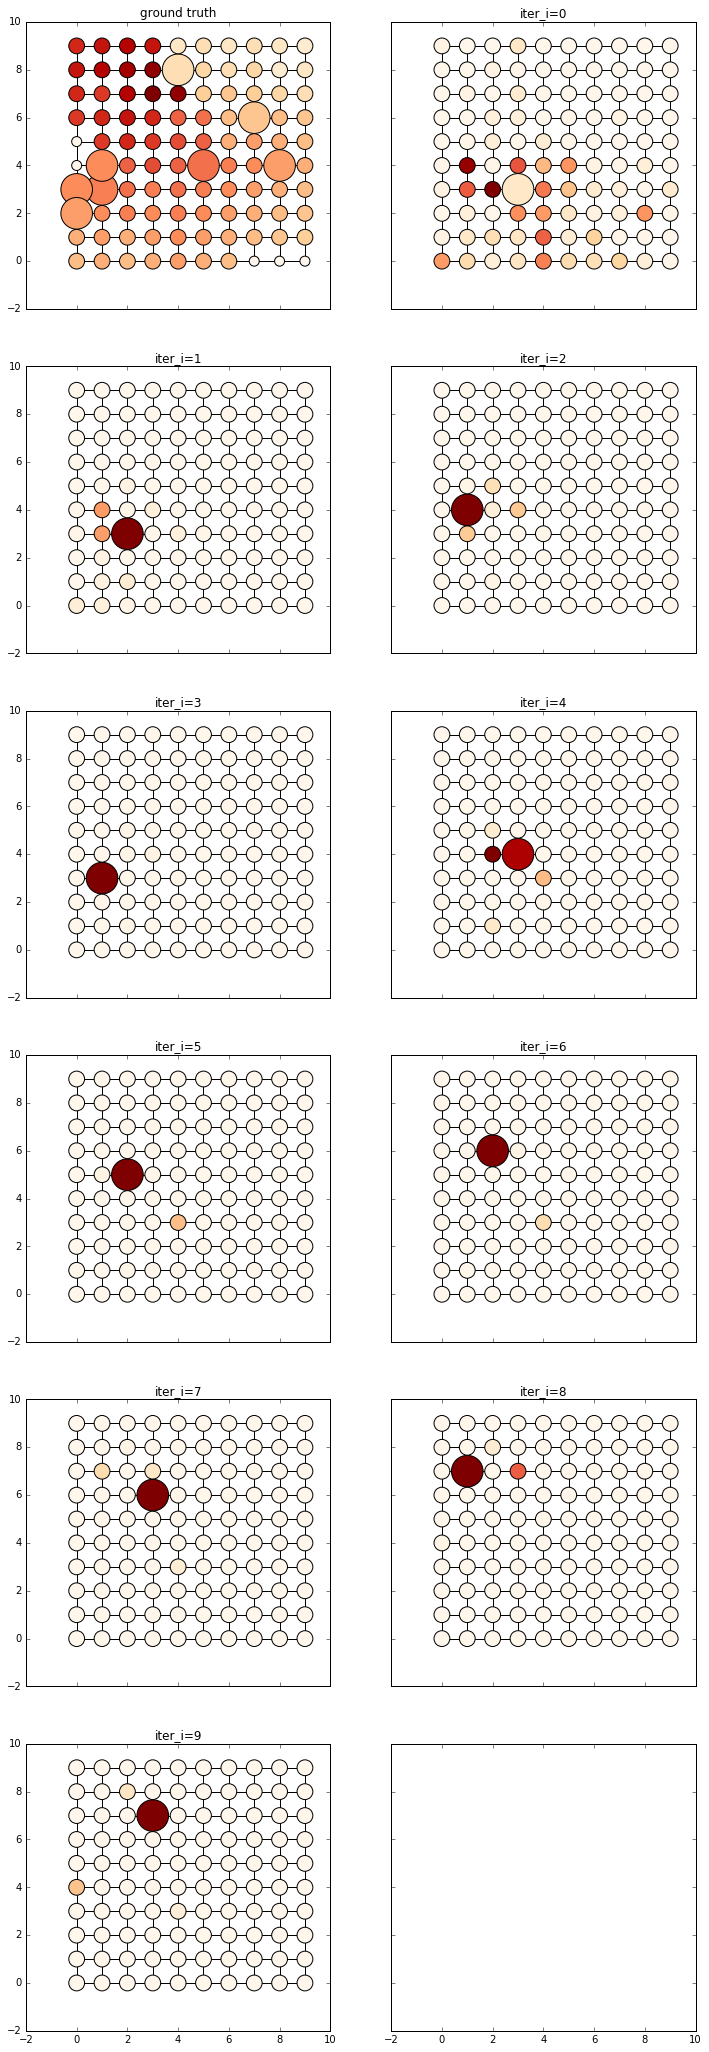

In [39]:
obs, times, tree, mu = inputs[-1]
mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
mwu(g, obs, times, 
    p_on_mu=abs(infp-0.5) + 0.5,
    mu=mu,
    max_iter=float('inf'), debug=True, plot=True)

In [59]:
def baseline_dog_tracker(g, obs_nodes, infection_times):
    query_count = 0
    q = min(obs_nodes, key=lambda n: infection_times[n])
    while True:
        if q not in obs_nodes:
            query_count += 1
            obs_nodes.add(q)
            
        found_source = True
        for u in g.neighbors(q):
            if u not in obs_nodes:  # need to query it
                obs_nodes.add(u)
                query_count += 1            

            if infection_times[q] > infection_times[u]:
                # q later than u                    
                found_source = False
                # found the direction
                if infection_times[q] - infection_times[u] == g[q][u]['d']:
                    q = u
                    break
        if found_source:
            source = q
            expected = min(infection_times, key=lambda n: infection_times[n])
            print('**Found** source: {}'.format(source))
            assert source == expected            
            break
    return query_count
        


In [64]:
infp = 0.7
g = prepare_standard_infection_graph(g, infp)

p_on_mu = abs(infp-0.5) + 0.5
fraction = 0.05
K=100
M=5
N = 50
cnts = []
inputs = []
for i in range(N):
    print('experiment {}'.format(i+1))
    obs_nodes, infection_times, tree = make_input(g, infp, fraction)
    mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
    
    inputs.append(
        (obs_nodes, infection_times, tree, mu)
    )

    c = mwu(g, obs_nodes,
            infection_times, 
            p_on_mu,
            mu,
            max_iter=float('inf'), debug=False)
    cnts.append(c)
    print()

experiment 1
4/89 samples
**Found** source: (4, 0)
query count 6

experiment 2
4/97 samples
**Found** source: (4, 8)
query count 10

experiment 3
4/97 samples
**Found** source: (4, 2)
query count 9

experiment 4
4/96 samples
**Found** source: (9, 2)
query count 5

experiment 5
4/97 samples
**Found** source: (0, 8)
query count 11

experiment 6
4/92 samples
**Found** source: (2, 9)
query count 9

experiment 7
4/95 samples
**Found** source: (5, 7)
query count 6

experiment 8
4/98 samples
**Found** source: (8, 2)
query count 9

experiment 9
4/93 samples
**Found** source: (7, 9)
query count 10

experiment 10
4/98 samples
**Found** source: (4, 9)
query count 11

experiment 11
4/97 samples
**Found** source: (1, 3)
query count 13

experiment 12
4/92 samples
**Found** source: (4, 4)
query count 10

experiment 13
4/85 samples
**Found** source: (8, 9)
query count 28

experiment 14
4/98 samples
**Found** source: (4, 9)
query count 12

experiment 15
4/98 samples
**Found** source: (6, 9)
query count

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/dist-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f87658a7b70, file "/...3.5/dist-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/dist-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/dist-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f87658a7b70, file "/...3.5/dist-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/dist-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "infp = 0.7\ng = prepare_standard_infection_graph(...nf'), debug=False)\n    cnts.append(c)\n    print()", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-02-14T14:14:48.340362', 'msg_id': '37605C63994E4D5F84F6936F159E139D', 'msg_type': 'execute_request', 'session': '4DB15401980B4342802624D9F8668AD1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '37605C63994E4D5F84F6936F159E139D', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'4DB15401980B4342802624D9F8668AD1']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "infp = 0.7\ng = prepare_standard_infection_graph(...nf'), debug=False)\n    cnts.append(c)\n    print()", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-02-14T14:14:48.340362', 'msg_id': '37605C63994E4D5F84F6936F159E139D', 'msg_type': 'execute_request', 'session': '4DB15401980B4342802624D9F8668AD1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '37605C63994E4D5F84F6936F159E139D', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'4DB15401980B4342802624D9F8668AD1'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "infp = 0.7\ng = prepare_standard_infection_graph(...nf'), debug=False)\n    cnts.append(c)\n    print()", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-02-14T14:14:48.340362', 'msg_id': '37605C63994E4D5F84F6936F159E139D', 'msg_type': 'execute_request', 'session': '4DB15401980B4342802624D9F8668AD1', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '37605C63994E4D5F84F6936F159E139D', 'msg_type': 'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="infp = 0.7\ng = prepare_standard_infection_graph(...nf'), debug=False)\n    cnts.append(c)\n    print()", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "infp = 0.7\ng = prepare_standard_infection_graph(...nf'), debug=False)\n    cnts.append(c)\n    print()"
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="infp = 0.7\ng = prepare_standard_infection_graph(...nf'), debug=False)\n    cnts.append(c)\n    print()", store_history=True, silent=False, shell_futures=True)
   2700                 self.displayhook.exec_result = result
   2701 
   2702                 # Execute the user code
   2703                 interactivity = "none" if silent else self.ast_node_interactivity
   2704                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2705                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2706                 
   2707                 self.last_execution_succeeded = not has_raised
   2708 
   2709                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-64-975cb977d446>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f87434337f0, executi..._before_exec=None error_in_exec=None result=None>)
   2804 
   2805         try:
   2806             for i, node in enumerate(to_run_exec):
   2807                 mod = ast.Module([node])
   2808                 code = compiler(mod, cell_name, "exec")
-> 2809                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f87226c1780, file "<ipython-input-64-975cb977d446>", line 11>
        result = <ExecutionResult object at 7f87434337f0, executi..._before_exec=None error_in_exec=None result=None>
   2810                     return True
   2811 
   2812             for i, node in enumerate(to_run_interactive):
   2813                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f87226c1780, file "<ipython-input-64-975cb977d446>", line 11>, result=<ExecutionResult object at 7f87434337f0, executi..._before_exec=None error_in_exec=None result=None>)
   2864         outflag = 1  # happens in more places, so it's easier as default
   2865         try:
   2866             try:
   2867                 self.hooks.pre_run_code_hook()
   2868                 #rprint('Running code', repr(code_obj)) # dbg
-> 2869                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f87226c1780, file "<ipython-input-64-975cb977d446>", line 11>
        self.user_global_ns = {'In': ['', "get_ipython().magic('matplotlib inline')\nimport ... import tqdm\nfrom joblib import Parallel, delayed", 'seed = 123456\nrandom.seed(seed)\nnp.random.seed(seed)', "def sample_graph_from_infection(g):\n    g_bone =...= g_bone[i][j]['p']        \n        \n    return g", 'def simulate_IC(g, s=None, debug=False):\n    """...tems())\n    return infection_time, infection_tree', "def prepare_standard_infection_graph(g, p):\n    ..._color': node_colors,\n            'cmap': 'OrRd'}", "def add_colorbar(cvalues, cmap='OrRd'):\n    eps ... scm.set_array(cvalues)\n    plt.colorbar(scm)    ", 'def make_input(g, infp, fraction):\n    while Tru...\n    return orig_obs_nodes, infection_times, tree', 'def get_nodes_on_and_off_direction(g, start, end... neg_nodes.add(t)\n    return pos_nodes, neg_nodes', '# multiplicative weight update method\n# initial ...ltiplicated_weight_update(g, mu, infection_time):', "g = prepare_standard_infection_graph(g, infp)\nin...inf'), debug=True)\n    cnts.append(c)\n    print()", 'n = 10\ng = nx.grid_2d_graph(n, n)\nfor i, j in g....rkx(g, pos=pos, with_labels=False, node_size=150)', "g = prepare_standard_infection_graph(g, infp)\nin...inf'), debug=True)\n    cnts.append(c)\n    print()", "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", "\ndef simulate_on_node_as_source(g, s, K, order_c... r['mu'] for i, r in df.iterrows()}\n    return mu", "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", '# multiplicative weight update method\n# initial ...ltiplicated_weight_update(g, mu, infection_time):', "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", '# multiplicative weight update method\n# initial ...ltiplicated_weight_update(g, mu, infection_time):', "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", ...], 'K': 100, 'M': 5, 'N': 50, 'Out': {22: 11, 34: 20, 39: 19, 42: [7, 9, 9, 7, 11, 7, 6, 8, 6, 6, 11, 6, 7, 9, 9, 5, 8, 10, 8, 8, ...], 43: 8.1400000000000006, 45: count    50.000000
mean      8.140000
std       ...      10.000000
max      21.000000
dtype: float64, 54: count    50.000000
mean      7.320000
std       ...       8.750000
max      14.000000
dtype: float64, 56: count     8.000000
mean      9.750000
std       ...      13.000000
max      17.000000
dtype: float64, 58: count    50.000000
mean     10.540000
std       ...      13.000000
max      19.000000
dtype: float64, 61: count    50.000000
mean     10.920000
std       ...      14.000000
max      30.000000
dtype: float64, ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'SQLContext': <class 'pyspark.sql.context.SQLContext'>, 'SparkContext': <class 'pyspark.context.SparkContext'>, 'SparkSession': <class 'pyspark.sql.session.SparkSession'>, 'StorageLevel': <class 'pyspark.storagelevel.StorageLevel'>, ...}
        self.user_ns = {'In': ['', "get_ipython().magic('matplotlib inline')\nimport ... import tqdm\nfrom joblib import Parallel, delayed", 'seed = 123456\nrandom.seed(seed)\nnp.random.seed(seed)', "def sample_graph_from_infection(g):\n    g_bone =...= g_bone[i][j]['p']        \n        \n    return g", 'def simulate_IC(g, s=None, debug=False):\n    """...tems())\n    return infection_time, infection_tree', "def prepare_standard_infection_graph(g, p):\n    ..._color': node_colors,\n            'cmap': 'OrRd'}", "def add_colorbar(cvalues, cmap='OrRd'):\n    eps ... scm.set_array(cvalues)\n    plt.colorbar(scm)    ", 'def make_input(g, infp, fraction):\n    while Tru...\n    return orig_obs_nodes, infection_times, tree', 'def get_nodes_on_and_off_direction(g, start, end... neg_nodes.add(t)\n    return pos_nodes, neg_nodes', '# multiplicative weight update method\n# initial ...ltiplicated_weight_update(g, mu, infection_time):', "g = prepare_standard_infection_graph(g, infp)\nin...inf'), debug=True)\n    cnts.append(c)\n    print()", 'n = 10\ng = nx.grid_2d_graph(n, n)\nfor i, j in g....rkx(g, pos=pos, with_labels=False, node_size=150)', "g = prepare_standard_infection_graph(g, infp)\nin...inf'), debug=True)\n    cnts.append(c)\n    print()", "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", "\ndef simulate_on_node_as_source(g, s, K, order_c... r['mu'] for i, r in df.iterrows()}\n    return mu", "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", '# multiplicative weight update method\n# initial ...ltiplicated_weight_update(g, mu, infection_time):', "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", '# multiplicative weight update method\n# initial ...ltiplicated_weight_update(g, mu, infection_time):', "infp = 0.7\ng = prepare_standard_infection_graph(...inf'), debug=True)\n    cnts.append(c)\n    print()", ...], 'K': 100, 'M': 5, 'N': 50, 'Out': {22: 11, 34: 20, 39: 19, 42: [7, 9, 9, 7, 11, 7, 6, 8, 6, 6, 11, 6, 7, 9, 9, 5, 8, 10, 8, 8, ...], 43: 8.1400000000000006, 45: count    50.000000
mean      8.140000
std       ...      10.000000
max      21.000000
dtype: float64, 54: count    50.000000
mean      7.320000
std       ...       8.750000
max      14.000000
dtype: float64, 56: count     8.000000
mean      9.750000
std       ...      13.000000
max      17.000000
dtype: float64, 58: count    50.000000
mean     10.540000
std       ...      13.000000
max      19.000000
dtype: float64, 61: count    50.000000
mean     10.920000
std       ...      14.000000
max      30.000000
dtype: float64, ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'SQLContext': <class 'pyspark.sql.context.SQLContext'>, 'SparkContext': <class 'pyspark.context.SparkContext'>, 'SparkSession': <class 'pyspark.sql.session.SparkSession'>, 'StorageLevel': <class 'pyspark.storagelevel.StorageLevel'>, ...}
   2870             finally:
   2871                 # Reset our crash handler in place
   2872                 sys.excepthook = old_excepthook
   2873         except SystemExit as e:

...........................................................................
/home/cloud-user/code/source_finding/<ipython-input-64-975cb977d446> in <module>()
      9 cnts = []
     10 inputs = []
     11 for i in range(N):
     12     print('experiment {}'.format(i+1))
     13     obs_nodes, infection_times, tree = make_input(g, infp, fraction)
---> 14     mu = estimate_source_likelihood(g, K, M, obs_nodes, infection_times)
     15     
     16     inputs.append(
     17         (obs_nodes, infection_times, tree, mu)
     18     )

...........................................................................
/home/cloud-user/code/source_finding/<ipython-input-14-a1a851e74468> in estimate_source_likelihood(g=<networkx.classes.graph.Graph object>, K=100, M=5, obs_nodes={(3, 4), (4, 7), (6, 9)}, infection_times={(0, 0): 17, (0, 1): 16, (0, 2): 17, (0, 3): 16, (0, 4): 15, (0, 5): 16, (0, 6): 17, (0, 7): 18, (0, 8): 19, (0, 9): 20, ...})
     17                 success_cnt += 1
     18     return s, success_cnt
     19 
     20 def estimate_source_likelihood(g, K, M, obs_nodes, infection_times):
     21     result = Parallel(n_jobs=-1)(delayed(simulate_on_node_as_source)(g, s, K, M, obs_nodes, infection_times)
---> 22                                  for s in g.nodes())
     23     df = pd.DataFrame(result, columns=['node', 'cnt'])
     24     df['mu'] = df['cnt'] / K
     25 
     26     # stored here

...........................................................................
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object estimate_source_likelihood.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Feb 14 14:21:06 2017
PID: 31299                                   Python 3.5.2: /usr/bin/python3
...........................................................................
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function simulate_on_node_as_source>, (<networkx.classes.graph.Graph object>, (7, 3), 100, 5, {(3, 4), (4, 7), (6, 9)}, {(0, 0): 17, (0, 1): 16, (0, 2): 17, (0, 3): 16, (0, 4): 15, (0, 5): 16, (0, 6): 17, (0, 7): 18, (0, 8): 19, (0, 9): 20, ...}), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function simulate_on_node_as_source>
        args = (<networkx.classes.graph.Graph object>, (7, 3), 100, 5, {(3, 4), (4, 7), (6, 9)}, {(0, 0): 17, (0, 1): 16, (0, 2): 17, (0, 3): 16, (0, 4): 15, (0, 5): 16, (0, 6): 17, (0, 7): 18, (0, 8): 19, (0, 9): 20, ...})
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/cloud-user/code/source_finding/<ipython-input-14-a1a851e74468> in simulate_on_node_as_source(g=<networkx.classes.graph.Graph object>, s=(7, 3), K=100, order_constraint_n=5, obs_nodes={(3, 4), (4, 7), (6, 9)}, infection_times={(0, 0): 17, (0, 1): 16, (0, 2): 17, (0, 3): 16, (0, 4): 15, (0, 5): 16, (0, 6): 17, (0, 7): 18, (0, 8): 19, (0, 9): 20, ...})
      1 
      2 
      3 def simulate_on_node_as_source(g, s, K, order_constraint_n, obs_nodes, infection_times):
      4     success_cnt = 0
----> 5     if order_constraint_n:
      6         ordered_pairs = random.sample(list(combinations(obs_nodes, 2)), order_constraint_n)
      7         ground_truth = np.array([infection_times[u] > infection_times[v] for u, v in ordered_pairs])
      8 
      9     for i in range(K):
     10         times, _ = simulate_IC(g, s=s)
     11         inf_nodes = filter(lambda n: not np.isinf(times[n]), times)

...........................................................................
/usr/lib/python3.5/random.py in sample(self=<random.Random object>, population=[((4, 7), (6, 9)), ((4, 7), (3, 4)), ((6, 9), (3, 4))], k=5)
    310         if not isinstance(population, _Sequence):
    311             raise TypeError("Population must be a sequence or set.  For dicts, use list(d).")
    312         randbelow = self._randbelow
    313         n = len(population)
    314         if not 0 <= k <= n:
--> 315             raise ValueError("Sample larger than population")
    316         result = [None] * k
    317         setsize = 21        # size of a small set minus size of an empty list
    318         if k > 5:
    319             setsize += 4 ** _ceil(_log(k * 3, 4)) # table size for big sets

ValueError: Sample larger than population
___________________________________________________________________________

In [66]:
s1 = pd.Series(cnts)
s1.describe()

count    39.000000
mean      9.641026
std       3.923527
min       4.000000
25%       7.500000
50%       9.000000
75%      11.000000
max      28.000000
dtype: float64

In [71]:
cnts = []
for i in tqdm(range(N)):
    obs_nodes, infection_times, tree = make_input(g, infp, fraction)
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    cnts.append(c)

 32%|███▏      | 16/50 [00:00<00:00, 72.65it/s]

5/100 samples
**Found** source: (1, 9)
5/100 samples
**Found** source: (7, 9)
4/94 samples
**Found** source: (3, 2)
4/99 samples
**Found** source: (7, 8)
3/72 samples
**Found** source: (4, 3)
4/96 samples
**Found** source: (4, 0)
5/100 samples
**Found** source: (7, 2)
4/91 samples
**Found** source: (3, 5)
4/97 samples
**Found** source: (9, 1)
4/95 samples
**Found** source: (5, 3)
4/94 samples
**Found** source: (0, 3)
4/99 samples
**Found** source: (6, 6)
3/90 samples
**Found** source: (0, 2)
4/99 samples
**Found** source: (6, 3)
4/95 samples
**Found** source: (8, 0)
3/96 samples
**Found** source: (7, 4)
4/92 samples
**Found** source: (3, 1)


 70%|███████   | 35/50 [00:00<00:00, 80.77it/s]

4/99 samples
**Found** source: (1, 2)
4/92 samples
**Found** source: (2, 1)
3/94 samples
**Found** source: (9, 1)
4/95 samples
**Found** source: (2, 2)
4/94 samples
**Found** source: (3, 4)
4/97 samples
**Found** source: (5, 6)
4/98 samples
**Found** source: (5, 3)
4/93 samples
**Found** source: (4, 3)
4/98 samples
**Found** source: (6, 9)
4/98 samples
**Found** source: (2, 2)
4/93 samples
**Found** source: (6, 4)
4/99 samples
**Found** source: (2, 0)
4/99 samples
**Found** source: (4, 2)
4/99 samples
**Found** source: (9, 7)
4/97 samples
**Found** source: (2, 5)
4/96 samples
**Found** source: (3, 1)
4/95 samples
**Found** source: (2, 2)
4/96 samples
**Found** source: (8, 1)
5/100 samples
**Found** source: (3, 4)
4/97 samples
**Found** source: (8, 0)
3/99 samples
**Found** source: (2, 7)


100%|██████████| 50/50 [00:00<00:00, 91.13it/s]

4/98 samples
**Found** source: (2, 1)
4/97 samples
**Found** source: (2, 4)
4/99 samples
**Found** source: (2, 4)
4/99 samples
**Found** source: (0, 5)
4/99 samples
**Found** source: (9, 1)
4/98 samples
**Found** source: (4, 6)
4/94 samples
**Found** source: (5, 4)
4/99 samples
**Found** source: (2, 0)
4/93 samples
**Found** source: (8, 5)
4/98 samples
**Found** source: (8, 5)
4/98 samples
**Found** source: (3, 6)
4/93 samples
**Found** source: (4, 9)


In [72]:
s2 = pd.Series(cnts)
s2.describe()

count    50.000000
mean     10.180000
std       3.947047
min       4.000000
25%       7.000000
50%       9.000000
75%      13.000000
max      21.000000
dtype: float64

In [82]:
cmp = pd.DataFrame.from_dict({'multiplicative': s1.describe(), 'baseline': s2.describe()})
cmp

,baseline,multiplicative
count,50.000000,39.000000
mean,10.180000,9.641026
std,3.947047,3.923527
min,4.000000,4.000000
25%,7.000000,7.500000
50%,9.000000,9.000000
75%,13.000000,11.000000
max,21.000000,28.000000


In [ ]:
infection_times = obs_infection_times
nodes = obs_nodes

In [ ]:
def reverse_infection():
    u = max(nodes, key=lambda n: infection_times[n])
    tmax = infection_times[u]
    O = copy(nodes)
    infection_times = copy(infection_times)
    queue = [u]
    found = False
    time = max(infection_times.values())
    m = defaultdict(set)
    while not found:
        obs_i = filter(lambda n: infection_times[n] == time, O)
        for u in obs_i:
            for v in g.neighbors(u):
                if u not in m[v] or (infection_times[u] < time - g[u][v]['d']):
                    m[v]